# Some models of Classifiers
### *Some experiments that compares Nearest Neighbour, Softmax, LinearSVM and Two Layer Neural Network*

We use the case study and the techniques learned through the [CS231n Convolutional Neural Networks for Visual Recognition course](http://cs231n.stanford.edu/) held at Stanford University in the spring of 2018. At the base there is the idea of creating the model of a classifier able to divide a set of data difficult to separate linearly.

For this purpose we first generate our dataset linked to the corresponding labels.

In [0]:
# Generation of a case study 

import numpy as np
import random
import matplotlib.pyplot as plt

N = 500 # number of points per class
D = 2 # dimensionality
K = 8 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels

for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  
  for i in range (D):
    X[ix, i] = (i == 0)*(r*np.sin(t)) + (i == 1)*(r*np.cos(t)) + (i > 1)*(r**i)*((np.sin(t)**2 + np.cos(t)**2)) 
  
  y[ix] = j

The X dataset contains the coordinates in the space (in this case a 2-dimensional space) of our points. </br>
At the same time Y contains the corresponding label for each point.

In [2]:
print('Dimension of Dataset X:', X.shape, 'Dimension of Labels y:', y.shape)

Dimension of Dataset X: (4000, 2) Dimension of Labels y: (4000,)


Consider that in our experimets we show two and later three dimensions dataset but, except for visualization, the algorithms can be used with datasets with a larger number of dimensions. Then, we visualize our data. 


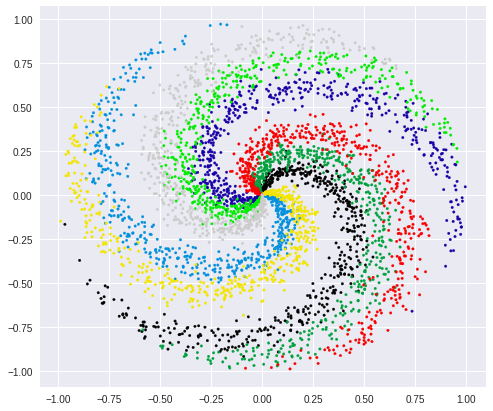

In [3]:
fig = plt.figure(figsize=(8,7))

ax = fig.add_subplot(111)
ax.scatter(X[:, 0], X[:, 1], c=y, marker='.', s=25, cmap=plt.cm.nipy_spectral)

plt.show()

At the moment the first N points correspond to the '0' Label, the N seconds to the '1' Label, the third to the '2' Label, etc...

For an effective experiment, we shuflle our data.

In [4]:
# let's mix the deck of cards (our dataset) 

n_example = X.shape[0]
index = np.arange(n_example)
random.shuffle(index)

print('Our first 20 labels before shuffle: ', y[:20])

X = X[index]
y = y[index]

print('Our first 20 labels after shuffle: ', y[:20])

Our first 20 labels before shuffle:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Our first 20 labels after shuffle:  [7 1 4 1 4 3 3 4 1 3 2 2 2 4 4 6 0 0 7 1]


For our toy experiment we use the same distribution for training/validation/test sets. 
The validation/test sets will be two tenth of the original dataset in size.

In [5]:
# We subdivide the dataset between Training / Validation / Test set

val_dim = int(np.ceil(n_example * .2))
test_dim = int(np.ceil(n_example * .2))
train_dim = n_example - (val_dim + test_dim)

X_train, X_val, X_test = X[:train_dim], X[train_dim:train_dim+val_dim], X[train_dim+val_dim:]
y_train, y_val, y_test = y[:train_dim], y[train_dim:train_dim+val_dim], y[train_dim+val_dim:] 

print('Dimension of X:')
print('  | X Training set = {} | X Validation set = {} | X Test set = {} |' .format(X_train.shape, X_val.shape, X_test.shape), '\n')
print('Corresponding labels Y:')
print('  | Y Train = {}          | Y Val = {}              | Y Test = {}       |' .format(y_train.shape, y_val.shape, y_test.shape))

# Let free a little memory
del(X) 
del(y)

Dimension of X:
  | X Training set = (2400, 2) | X Validation set = (800, 2) | X Test set = (800, 2) | 

Corresponding labels Y:
  | Y Train = (2400,)          | Y Val = (800,)              | Y Test = (800,)       |


## Definition of the Classifier object
Consider the problem of predicting the belonging of an observation to a certain class of objects. This task can be solved with a category of algorithms known as classifiers. A classifier performs predictions on the basis of previous examples - we could say based on experience.

The basic comparison term to measure the performance of our algorithms consists in carry out predictions exclusively based on randomness. On our starting dataset prediction based on randomness will have the following performances on validation data.


In [6]:
# With K label, each of our observations has a 1/K probability of being classified with a particular class

prediction = np.random.randint(K, size=len(y_val))

acc = np.mean(prediction == y_val)

print('Accuracy Validation set:', acc, '\n\nIts value should not deviate too much from probability of 1/K that is', 1/K)

Accuracy Validation set: 0.1275 

Its value should not deviate too much from probability of 1/K that is 0.125


## Nearest Neighbor Classifier
We can now try a rather simple approach, with surprising results for the kind of problem we have posed. We are talking about the Nearest Neighbor, a classifier that, as we shall see, offers interesting results in the specific case, but a series of equally important issues.

The Nearest Neighbor establishes the class of new observations based on the distance from the training set observations: it assigns the class to which the nearest neighbors belong. In this algorithm the training phase consists in memorizing the training set. Subsequently, the forecast takes place by measuring the distance of the observation from the nearest neighbor (we use L1 distance, but you can try also L2 distance).

In [0]:
class NearestNeighbor(object):
  
  def __init__(self, dist='L1'):
    self.dist = dist
    pass

  def train(self, X, y):
    # As we know from Stanford course the nearest neighbor 
    # classifier simply remembers all the training data
    
    self.Xtr = X
    self.ytr = y

  def predict(self, X):

    num_test = X.shape[0]
    
    # lets make sure that the output type matches the input type
    Ypred = np.zeros(num_test, dtype = self.ytr.dtype)

    # loop over all test rows
    for i in range(num_test):
      
      # find the nearest training image to the i'th test image
      if self.dist == 'L1':     # using a L1 (or Mamhattan) distance
        distances = np.sum(np.abs(self.Xtr - X[i,:]), axis = 1)
      elif self.dist == 'L2':   # using a L2 (or euclidean) distance
        distances = np.sqrt(np.sum(np.square(self.Xtr - X[i,:]), axis = 1))
        
      min_index = np.argmin(distances) # get the index with smallest distance
      Ypred[i] = self.ytr[min_index] # predict the label of the nearest example

    return Ypred

As we can see, the performance of this algorithm is quite good with our specific dataset.

In [8]:
Cls = NearestNeighbor() # NearestNeighbor('L2') to use L2 distance
Cls.train(X_train, y_train)
prediction = Cls.predict(X_val)

acc = np.mean(prediction == y_val)

print('Accuracy Validation set of Nearest Neighbor Classifier:', acc)

Accuracy Validation set of Nearest Neighbor Classifier: 0.815


A rather useful way to have a visual representation of the efficiency of our algorithm is the graphic representation of the decision boundary. 

We can thus visualize a mapping of the predictions of our algorithm. This is what the following function does.

In [0]:
def plot_db2d(X,y, title, Cls):

  fig = plt.figure(figsize=(8, 7))

  x_min, x_max = min(X[:, 0]) - .1, max(X[:, 0]) + .1
  y_min, y_max = min(X[:, 1]) - .1, max(X[:, 1]) + .1

  xx = np.arange(x_min, x_max, 0.01)
  yy = np.arange(y_min, y_max, 0.01)

  xplot, yplot = np.array(np.meshgrid(xx, yy))

  Z = Cls.predict(np.c_[xplot.ravel(), yplot.ravel()])
  Z = Z.reshape(xplot.shape)
 
  ax = fig.add_subplot(1, 1, 1)
  ax.set_title(title, fontsize=18)  
  ax.scatter(X[:,0], X[:,1], c=y, marker='.', s=50, cmap=plt.cm.nipy_spectral)
  
  ax.contourf(xplot, yplot, Z, alpha=0.2, cmap=plt.cm.nipy_spectral)
  ax.contour(xplot, yplot, Z, linewidths=.1, colors='black')
    
  plt.show()

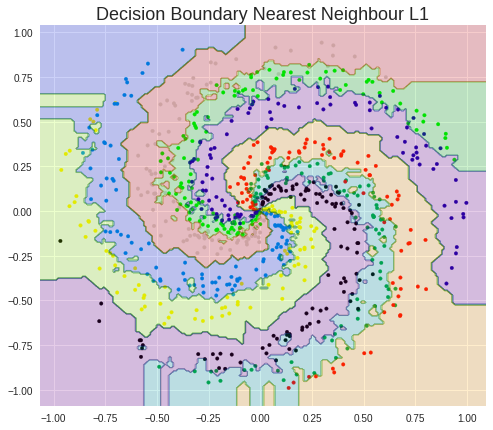

In [10]:
plot_db2d(X_test, y_test, 'Decision Boundary Nearest Neighbour L1', Cls)

### A big problem
*However, this algorithm has a big problem, it is not very efficient. In fact, it is quick in training (it needs a defined time for storing the training set), but it is slow in the prediction phase (it must compare the new observation with the whole training set.*

### Linear Classifiers
Now let's try a different approach with Linear Classifiers. Its includes the Multiclass Support Vector Machine and the Softmax that we will use. The advantage they offer is to have a quick prediction phase - to the detriment of the training phase which will require a longer execution time. As we will see, their results do not differ much from each other; and they only succeed in barely improving the performance of a predictor totally entrusted to chance. 

As in the case of Neighbor Nearest, our classification algorithms are divided into two: the training phase and the prediction phase. With the first we introduce the concept of loss function, which is a learning measure of our algorithm. In fact, the Loss function measures a distance between the predictions of the algorithm and the actual class of belonging of our examples. Our goal in the training phase is to reduce the loss function value using optimization techniques.

In [0]:
class LinearClassifier(object):

  def __init__(self):
    self.W = None

  def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=100, verbose=False):

    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
    if self.W is None:
      # lazily initialize W
      self.W = 0.001 * np.random.randn(dim, num_classes)

    # Run stochastic gradient descent to optimize W
    loss_history = []
    history = {}

    for it in range(num_iters):
      index = np.random.choice(num_train, batch_size)
      X_batch = X[index,:]
      y_batch = y[index]

      # evaluate loss and gradient
      loss, grad = self.loss(X_batch, y_batch, reg)
      loss_history.append(loss)
    
      self.W -= learning_rate * grad
      
      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

    return loss_history

  def predict(self, X):
    y_pred = np.zeros(X.shape[0])
    y_pred = np.argmax(np.dot(X, self.W),axis=1)
    
    return y_pred
  
  def loss(self, X, y, reg):
    '''
    Compute the loss function and its derivative. 
    Subclasses will override this.

    Inputs:
    - X_batch: A numpy array of shape (N, D) containing a minibatch of N
      data points; each point has dimension D.
    - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
    - reg: (float) regularization strength.

    Returns: A tuple containing:
    - loss as a single float
    - gradient with respect to self.W; an array of the same shape as W
    '''
    pass    

The two algorithms that follow are essentially differentiated by the loss funcion they use.

### Softmax Classifier
Now we will try a Softmax Classifier. Here we define its loss function:

In [0]:
class Softmax(LinearClassifier):
  # A subclass that uses the Softmax + Cross-entropy loss function 

  def loss(self, X, y, reg):
    '''
    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    '''
    
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(self.W)
    num_train = X.shape[0]
    num_classes = self.W.shape[1]

    h = np.dot(X, self.W)
    h -= np.max(h, axis=1, keepdims=True)

    prob = np.divide(np.exp(h), np.sum(np.exp(h), axis=1, keepdims=True))

    true_class = prob[range(num_train), y]
    loss = np.sum(-np.log(true_class)) / num_train
    loss += 0.5 * reg * np.sum(self.W * self.W)

    prob[range(num_train),y] -= 1
    dW = np.dot(X.T, prob) / num_train

    return loss, dW


The following experiments show the learning ability of the Softmax with different hyper-parameters.

(We have carried out different tests and finally considered a narrow range of values for hyper parameters)


In [13]:
experiments = 20
Cls = Softmax()

best_cls = None
best_acc = -1
best_his = {}
best_his['Train Accuracy'] = None
  
for i in range(experiments):
  lr = np.random.uniform(5.9, 6.0)
  rg = np.random.uniform(.0002, .0003)
  bs = np.random.choice([256], replace=False)
  iters = 2500

  history = Cls.train(X_train, y_train, learning_rate=lr, reg=rg, num_iters=iters,
            batch_size=bs, verbose=False)
  print('n.{:3} | Train Loss: {:6.5g}  | Lr:{:9.4g} | Reg: {:9.4g} | Batches: {:0.0f}' .format(i, history[-1], lr,rg, bs))

  acc = np.mean((Cls.predict(X_val) == y_val))
  
  if acc > best_acc:
    best_acc, best_cls, best_his['Loss'] = acc, Cls, history
    v_loss, _ = Cls.loss(X_val, y_val, rg)
    print('------| Val Loss:   {:6.5f} | -----------------------------------> Val Acc: {:0.3f} <--'.format(v_loss, best_acc))

n.  0 | Train Loss: 1.6998  | Lr:    5.937 | Reg: 0.0002159 | Batches: 256
------| Val Loss:   1.75436 | -----------------------------------> Val Acc: 0.207 <--
n.  1 | Train Loss:  1.724  | Lr:    5.971 | Reg: 0.0002511 | Batches: 256
------| Val Loss:   1.75286 | -----------------------------------> Val Acc: 0.215 <--
n.  2 | Train Loss: 1.7645  | Lr:    5.994 | Reg: 0.0002669 | Batches: 256
------| Val Loss:   1.75912 | -----------------------------------> Val Acc: 0.216 <--
n.  3 | Train Loss: 1.6708  | Lr:    5.905 | Reg: 0.0002246 | Batches: 256
n.  4 | Train Loss: 1.7127  | Lr:    5.912 | Reg: 0.0002441 | Batches: 256
n.  5 | Train Loss: 1.7074  | Lr:    5.962 | Reg:   0.00027 | Batches: 256
n.  6 | Train Loss: 1.7156  | Lr:    5.936 | Reg: 0.0002776 | Batches: 256
n.  7 | Train Loss:   1.75  | Lr:    5.988 | Reg: 0.0002905 | Batches: 256
n.  8 | Train Loss: 1.7881  | Lr:    5.934 | Reg: 0.0002825 | Batches: 256
n.  9 | Train Loss: 1.7667  | Lr:    5.949 | Reg: 0.0002673 | Batch

With our dataset, Softmax predictive ability shows an accuracy with the validation set of around 20%. Really not much.

Let's see the learning curve. Here is the trend of the loss function of the training set, for the best of our experiments.

In [0]:
def plot_la(Cls_name, AccT, history):

  # Plot the loss function and train / validation accuracies
  
  if history:
    fig = plt.figure(figsize=(6, 4))
    plt.subplot(2, 1, 1)
    plt.plot(history['Loss'])
    plt.title('Loss history', fontsize=16)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()

    if history['Train Accuracy'] != None: 
      plt.subplot(2, 1, 2)
      plt.plot(history['Train Accuracy'], label='train')
      plt.plot(history['Val Accuracy'], label='val')
      plt.title('Classification accuracy history', fontsize=16)
      plt.xlabel('Epoch')
      plt.ylabel('Clasification accuracy')
      plt.legend()

    plt.show()
  
  print('_______________________________________________________________________\n')
  print('    Accuracy Test set of the best', type(Cls).__name__,':', AccT)
  print('_______________________________________________________________________')

As a last evidence, let's see how it behaves with the Test set.

In [15]:
Accuracy_Test = np.mean((best_cls.predict(X_test) == y_test))
Cls_name = type(Cls).__name__
plot_la(Cls_name, Accuracy_Test, None)

_______________________________________________________________________

    Accuracy Test set of the best Softmax : 0.19625
_______________________________________________________________________


And below we have the view of the decision boundary.

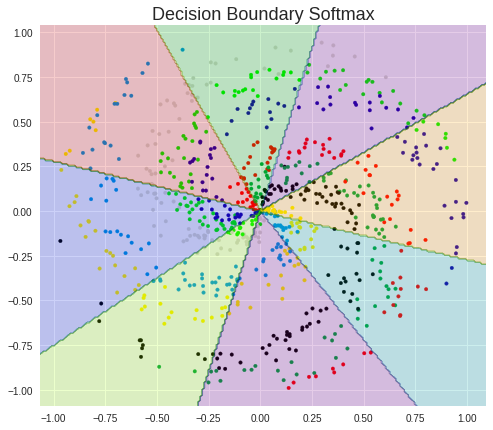

In [16]:
plot_db2d(X_test, y_test, 'Decision Boundary Softmax', Cls)

### Linear SVM Classifier
In the next series of experiments we will use a Multiclass Support Vector Machine classifier. As before we define its loss function:

In [0]:
class LinearSVM(LinearClassifier):
  # A subclass that uses the Multiclass SVM loss function
  
  def loss(self, X, y, reg):
    '''
    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    '''

    # initialize some values
    loss = 0.0
    dW = np.zeros(self.W.shape) 
    num_train = X.shape[0]
    delta = 1.0 # delta hyperparameter function is the same as reg 
                # then we can safely set it to 1.0

    # compute the loss
    scores = np.dot(X, self.W)

    mask = np.ones_like(scores)
    mask[range(num_train),y] = 0
    correct_class = scores[range(num_train), y]
    losses = np.maximum(0, (mask * (scores - correct_class[:, np.newaxis] + delta)))

    loss = np.sum(losses)

    # average loss of all training examples
    loss /= num_train

    # Add regularization to the loss
    loss += 0.5 * reg * np.sum(self.W * self.W)

    # compute gradients
    X_mask = np.zeros_like(losses)
    X_mask[losses > 0] = 1

    count = np.sum(X_mask, axis=1)
    X_mask[range(num_train), y] = -count

    dW = np.dot(X.T, X_mask)
    dW /= num_train

    # Add regularization to the gradient
    dW += np.multiply(self.W, reg)
    
    return loss, dW

Now we perform a series of experiments - considering an appropriate range of hyperparameters.

In [18]:
experiments = 20
Cls = LinearSVM()

best_cls = None
best_acc = -1
best_his = {}
best_his['Train Accuracy'] = None
  
for i in range(experiments):
  lr = 10 ** np.random.uniform(-3, -2)
  rg = 10 ** np.random.uniform(-6, -4)
  bs = np.random.choice([512], replace=False)
  iters = 1500

  history = Cls.train(X_train, y_train, learning_rate=lr, reg=rg, num_iters=iters,
            batch_size=bs, verbose=False)
  print('n.{:3} | Train Loss: {:6.5g}  | Lr:{:9.4g} | Reg: {:9.4g} | Batches: {:0.0f}' .format(i, history[-1], lr,rg, bs))

  acc = np.mean((Cls.predict(X_val) == y_val))
  
  if acc > best_acc:
    best_acc, best_cls, best_his['Loss'] = acc, Cls, history
    v_loss, _ = Cls.loss(X_val, y_val, rg)
    print('------| Val Loss:   {:6.5f} | -----------------------------------> Val Acc: {:0.3f} <--'.format(v_loss, best_acc))


n.  0 | Train Loss: 4.3983  | Lr: 0.007125 | Reg: 2.305e-06 | Batches: 512
------| Val Loss:   4.52133 | -----------------------------------> Val Acc: 0.201 <--
n.  1 | Train Loss: 4.4564  | Lr: 0.003502 | Reg: 4.877e-05 | Batches: 512
n.  2 | Train Loss: 4.5386  | Lr: 0.002009 | Reg: 1.308e-06 | Batches: 512
n.  3 | Train Loss: 4.1567  | Lr: 0.003818 | Reg: 7.179e-06 | Batches: 512
n.  4 | Train Loss: 4.3691  | Lr: 0.004027 | Reg: 5.852e-06 | Batches: 512
n.  5 | Train Loss: 4.3672  | Lr: 0.002628 | Reg: 2.767e-05 | Batches: 512
n.  6 | Train Loss: 4.2465  | Lr: 0.005932 | Reg: 2.852e-06 | Batches: 512
n.  7 | Train Loss: 4.4565  | Lr: 0.001007 | Reg: 1.937e-05 | Batches: 512
n.  8 | Train Loss: 4.2988  | Lr: 0.001584 | Reg: 9.319e-06 | Batches: 512
n.  9 | Train Loss: 4.2724  | Lr: 0.001255 | Reg: 2.895e-05 | Batches: 512
n. 10 | Train Loss:  4.361  | Lr: 0.002025 | Reg: 1.248e-05 | Batches: 512
n. 11 | Train Loss: 4.2481  | Lr: 0.007197 | Reg: 2.799e-06 | Batches: 512
n. 12 | Train 

With our dataset, Multiclass SVM predictive ability shows an accuracy with the validation set very close to that of Softmax. Still, not much.


In [19]:
Accuracy_Test = np.mean((best_cls.predict(X_test) == y_test))
Cls_name = type(Cls).__name__
plot_la(Cls_name, Accuracy_Test, None)

_______________________________________________________________________

    Accuracy Test set of the best LinearSVM : 0.205
_______________________________________________________________________


...let see the decision boundary.

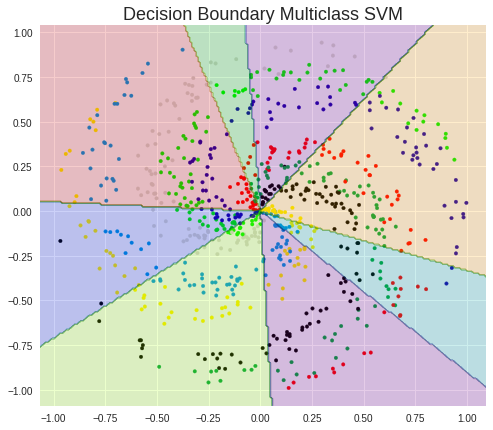

In [20]:
plot_db2d(X_test,y_test, 'Decision Boundary Multiclass SVM', Cls)

***As we know from the theory - and it is evident from our experiments - with a non linear problem like ours, a linear classifier fails to provide appreciable results.***

We now show the results we can achieve with a neural network. With our simple dataset we can use just an hidden layer, obtaining appreciable results.

### Two Layer Neural Network Classifier
We define our two layers Neural Network and his Loss Function:

In [0]:
class TwoLayerNet(object):

  def __init__(self, input_size, hidden_size, output_size, std=1e-4):
    ''' 
    Inputs:
    - input_size: The dimension D of the input data.
    - hidden_size: The number of neurons H in the hidden layer.
    - output_size: The number of classes C.
    '''
   
    self.params = {}
    self.params['W1'] = std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

  def loss(self, X, y=None, reg=0.0, dropout=1.0):
    '''
    Inputs:
    - X: Input data of shape (N, D). Each X[i] is a training sample.
    - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
      an integer in the range 0 <= y[i] < C. This parameter is optional; if it
      is not passed then we only return scores, and if it is passed then we
      instead return the loss and gradients.
    - reg: Regularization strength.

    Returns:
    If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
    the score for class c on input X[i].

    If y is not None, instead return a tuple of:
    - loss: Loss (data loss and regularization loss) for this batch of training
      samples.
    - grads: Dictionary mapping parameter names to gradients of those parameters
      with respect to the loss function; has the same keys as self.params.
    '''
    
    # Unpack variables from the params dictionary
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']
    N, D = X.shape
    
    # Compute the forward pass   
    s1 = np.dot(X, W1) + b1
    h1 = np.maximum(0, s1)  # ReLU
    dr = (np.random.rand(*h1.shape) < dropout) / dropout
    h1 *= dr # !dropout
    s2 = np.dot(h1, W2) + b2
    
    if y is None:
      return s2

    # Compute the loss
    s2 -= np.max(s2, axis=1, keepdims=True) # this not change any results, but improve numerical stability of computation 
    probs = np.exp(s2) / np.sum(np.exp(s2), axis=1, keepdims=True) # [N x K]
    probs_trueclass = probs[range(N), y]
    loss = np.sum(-np.log(probs_trueclass))/N 
    
    # regularization
    regularization = 0.5 * reg * (np.sum(W1*W1) + np.sum(W2*W2))
    loss = loss + regularization
    
    probs[range(N),y] -= 1
    
    #Back propagation
    grads = {}
    grads['W2'] = np.dot(h1.T, probs)/N + reg * W2
    grads['b2'] = np.sum(probs, axis = 0, keepdims=True)/N
    dhidden = np.dot(probs, W2.T)
    dhidden[h1 <= 0] = 0
    grads['W1'] = np.dot(X.T, dhidden)/N + reg * W1
    grads['b1'] = np.sum(dhidden, axis=0, keepdims=True)/N 

    return loss, grads


  def train(self, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=5e-6, num_iters=100,
            batch_size=200, verbose=False, dropout=1.0):
    '''
    Inputs:
    - X: A numpy array of shape (N, D) giving training data.
    - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
      X[i] has label c, where 0 <= c < C.
    - X_val: A numpy array of shape (N_val, D) giving validation data.
    - y_val: A numpy array of shape (N_val,) giving validation labels.
    - learning_rate: Scalar giving learning rate for optimization.
    - learning_rate_decay: Scalar giving factor used to decay the learning rate
      after each epoch.
    - reg: Scalar giving regularization strength.
    - num_iters: Number of steps to take when optimizing.
    - batch_size: Number of training examples to use per step.
    - verbose: boolean; if true print progress during optimization.
    '''    
    
    num_train = X.shape[0]
    iterations_per_epoch = max(num_train / batch_size, 1)

    # Use SGD to optimize the parameters in self.model
    loss_history = []
    train_acc_history = []
    val_acc_history = []

    for it in range(num_iters):
      X_batch = None
      y_batch = None

      rnd_index = np.random.choice(num_train, batch_size, replace=True)

      X_batch = X[rnd_index]
      y_batch = y[rnd_index]
      
      # Compute loss and gradients using the current minibatch
      loss, grads = self.loss(X_batch, y=y_batch, reg=reg, dropout=dropout)
      loss_history.append(loss)
      
      for param in grads:
        
        self.params[param] = self.params[param] - learning_rate * grads[param]

      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

      # Every epoch, check train and val accuracy and decay learning rate.
      if it % iterations_per_epoch == 0:
        # Check accuracy
        train_acc = (self.predict(X_batch) == y_batch).mean()
        val_acc = (self.predict(X_val) == y_val).mean()
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # Decay learning rate
        learning_rate *= learning_rate_decay

    return {
      'Loss': loss_history,
      'Train Accuracy': train_acc_history,
      'Val Accuracy': val_acc_history,
    }

  
  def predict(self, X):
    '''
    Inputs:
    - X: A numpy array of shape (N, D) giving N D-dimensional data points to
      classify.

    Returns:
    - y_pred: A numpy array of shape (N,) giving predicted labels for each of
      the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
      to have class c, where 0 <= c < C.
    '''
    
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']

    s1 = np.dot(X, W1) + b1
    h1 = np.maximum(0, s1) # ReLU
    s2 = np.dot(h1, W2) + b2

    y_pred = np.argmax(s2, axis=1)

    return y_pred

As previously we carry out a fair number of experiments. We use a series of random hyper-parameters:

In [22]:
history = {}
experiments = 20
best_acc = -1
input_size = X_train.shape[1]
hidden_size = 100
output_size = K

for i in range(experiments):
  lr = np.random.uniform(3, 6)
  rg = 10 ** np.random.uniform(-7, -3)
  bs = np.random.choice([256], replace=False)
  iters = 2000
  drpt = np.random.uniform(.7, .9)
  
  print('n. {}  Lr:{:9.6g}  |  Reg: {:9.4g} |  Batches: {:0.0f} |  Drpt: {:3.3f}' .format(i, lr,rg, bs, drpt))

  Cls = TwoLayerNet(input_size, hidden_size, output_size)
  history = Cls.train(X_train, y_train, X_val, y_val,
              num_iters=iters, batch_size=bs,
              learning_rate=lr, learning_rate_decay=0.95,
              reg=rg, verbose=False, dropout=drpt)
  
  acc = np.mean((Cls.predict(X_val) == y_val))
  print(history['Loss'][-1], acc)
  
  if acc > best_acc:
    best_acc, best_cls, best_his = acc, Cls, history
    print('- Init Loss:{:6.3f} -----------------------|  Final Loss: {:5.3f} | Val Acc:{:0.3f} |'.format(history['Loss'][0], history['Loss'][-1], best_acc))

n. 0  Lr:  5.90873  |  Reg: 6.655e-06 |  Batches: 256 |  Drpt: 0.851
0.7233344690435217 0.76125
- Init Loss: 2.079 -----------------------|  Final Loss: 0.723 | Val Acc:0.761 |
n. 1  Lr:  4.95299  |  Reg: 4.866e-05 |  Batches: 256 |  Drpt: 0.846
0.7172777629136965 0.805
- Init Loss: 2.079 -----------------------|  Final Loss: 0.717 | Val Acc:0.805 |
n. 2  Lr:  3.37731  |  Reg: 0.0004505 |  Batches: 256 |  Drpt: 0.870
0.9899597399961819 0.6875
n. 3  Lr:  3.20141  |  Reg: 0.0002523 |  Batches: 256 |  Drpt: 0.761
1.049627107465498 0.66625
n. 4  Lr:  3.59998  |  Reg: 0.0001061 |  Batches: 256 |  Drpt: 0.752
0.9590923771600933 0.7175
n. 5  Lr:  3.73469  |  Reg: 0.0005516 |  Batches: 256 |  Drpt: 0.797
1.0525707323637448 0.67875
n. 6  Lr:  4.26889  |  Reg: 7.333e-07 |  Batches: 256 |  Drpt: 0.826
0.5485967957720043 0.79875
n. 7  Lr:  4.77184  |  Reg: 0.0001211 |  Batches: 256 |  Drpt: 0.764
0.7811276419564921 0.76375
n. 8  Lr:  3.54364  |  Reg: 8.092e-05 |  Batches: 256 |  Drpt: 0.818
0.7798

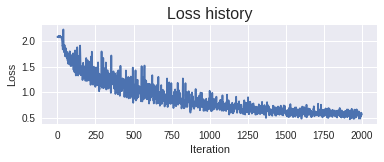

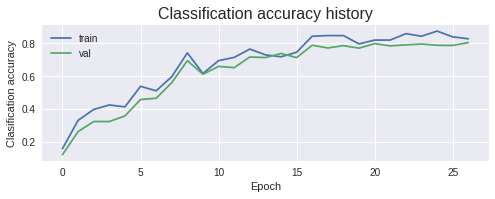

_______________________________________________________________________

    Accuracy Test set of the best TwoLayerNet : 0.8025
_______________________________________________________________________


In [23]:
Accuracy_Test = np.mean((best_cls.predict(X_test) == y_test))
Cls_name = type(Cls).__name__
plot_la(Cls_name, Accuracy_Test, best_his, )

And now we observe the decision boundary.

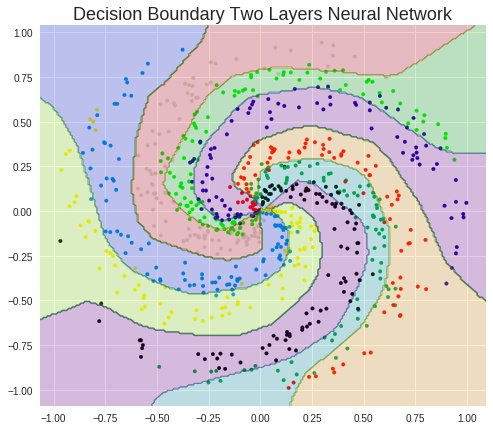

In [24]:
plot_db2d(X_test, y_test, 'Decision Boundary Two Layers Neural Network', Cls)

Using a neural network of just two layers, we achieved an optimal result. 

Viewing the decision boundaries also helps us to understand how our classifier has mapped the space of possible predictions.